In [2]:
"""
Deep Image Prior
https://arxiv.org/abs/1711.10925

test inpainting part

"""
print()

In [68]:
%matplotlib inline

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

# ## load image
# input_file = './pic_input/lenna_ori.png'
# output_path = './pic_output/'

# input_image = np.array(Image.open(input_file))[:, :, :3]
# print('input_image.shape: ', input_image.shape)
# plt.imshow(input_image)

In [130]:
## define function


def reflect_padding_layer(tf_input_image, kernel_size, stride):

    input_size = int(tf_input_image.get_shape()[1])
    output_size = int(np.ceil(input_size / stride))

    pad_size = int(np.ceil(((output_size - 1) * stride + kernel_size - input_size) * 0.5))
    tf_input_image = tf.pad(tf_input_image, 
                            [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], 
                            "REFLECT")
    
    return tf_input_image


def downsampling_layer(tf_input_image, n_d=128, k_d=7):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_d, stride=2)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=2, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_d, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_d, 
                                              kernel_size=k_d, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)
    
    return tf_input_image


def upsampling_layer(tf_input_image, n_u=128, k_u=7):

    height, width = tf_input_image.get_shape()[1:3]
    tf_input_image = tf.image.resize_images(tf_input_image, [height*2, width*2], 
                                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_u, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=k_u, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    # kernel_size=1
    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=1, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_u, 
                                              kernel_size=1, stride=1, 
                                              padding='VALID', activation_fn=None)
    tf_input_image = tf.contrib.layers.batch_norm(inputs=tf_input_image, 
                                                  activation_fn=tf.nn.leaky_relu)

    return tf_input_image



def skip_connections_layer(tf_input_image, n_s=0, k_s=0):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_s, stride=1)
    tf_input_image_sc = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_s, 
                                                 kernel_size=k_s, stride=1, 
                                                 padding='VALID', activation_fn=None)
    tf_input_image_sc = tf.contrib.layers.batch_norm(inputs=tf_input_image_sc, 
                                                     activation_fn=tf.nn.leaky_relu)

    ## use concat
    tf_input_image = tf.concat([tf_input_image, tf_input_image_sc], axis=3)

    return tf_input_image



def for_output_layer(tf_input_image, n_o=3, k_o=1):

    tf_input_image = reflect_padding_layer(tf_input_image, kernel_size=k_o, stride=1)
    tf_input_image = tf.contrib.layers.conv2d(inputs=tf_input_image, num_outputs=n_o, 
                                              kernel_size=k_o, stride=1, 
                                              padding='VALID', activation_fn=None)
    return tf_input_image


def image_save(path, img, reshape_size=[]):
    img = np.array(img)
#     img = img.reshape(reshape_size)
    img = np.clip(img, 0, 255).astype(np.uint8)
    Image.fromarray(img).save(path, quality=95)


def get_binary_text_mask(for_image, sz=20, position=(128, 128), text='hello world'):

    """
    refer from:
    https://github.com/DmitryUlyanov/deep-image-prior/blob/master/utils/inpainting_utils.py

    """

    font_fname = './font/FreeSansBold.ttf'
    font_size = sz
    font = ImageFont.truetype(font_fname, font_size)
    img_mask = Image.fromarray(np.array(for_image)*0+255)
    draw = ImageDraw.Draw(img_mask)
    draw.text(position, text, font=font, fill='rgb(0, 0, 0)')

    binary_mask_temp = np.array(img_mask)
    binary_mask = np.zeros_like(binary_mask_temp, dtype=np.float32)
    binary_mask += 1.0
    binary_mask[binary_mask_temp<254] -= 1.0

    return binary_mask


## build graph & run
def text_inpainting(input_image, n_u_list, n_d_list, k_u_list, k_d_list, n_s_list, k_s_list,
                    LR, num_iter, save_every_iter, show_every_iter, output_path, output_file_name,
                    image_normalize_TF, sigmoid_TF,addReg,mask,weight):

#     output_temp_path = output_path + 'temp/'
    output_temp_path = output_path

    if not os.path.exists(output_path):
        os.makedirs(output_path) 
    if not os.path.exists(output_temp_path):
        os.makedirs(output_temp_path)   

    image_shape = [shape for shape in input_image.shape[:-1]]
    output_image_shape = [1] + image_shape + [32]
   

    ## get mask
    binary_mask  = mask

    corrupted_image = np.multiply(input_image, binary_mask)
    corrupted_image = corrupted_image.astype(np.uint8)

    ## show image
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(1,3,1)
    ax1.set_title('original_image')
    ax1.imshow(input_image)
    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('binary_mask')
    ax2.imshow(binary_mask)
    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('corrupted_image')
    ax3.imshow(corrupted_image)
    plt.show()
    fig.savefig(output_path+'all_image.png', bbox_inches='tight')

    image_save(path=output_path+'binary_mask.png', img=binary_mask)
    image_save(path=output_path+'corrupted_image.png', img=corrupted_image)

    ## graph  (can improve here !!)
    print('image_normalize_TF: ', image_normalize_TF)  
    print('sigmoid_TF: ', sigmoid_TF)  

    print('\nmodel structure: ')
    input_image_shape = [1] + image_shape + [3]
    input_image = corrupted_image
    if image_normalize_TF:
        input_image = input_image / 255
    input_image = np.reshape(input_image, input_image_shape)    
    input_image = tf.constant(input_image, dtype=tf.float32)

    ## placeholder
    output_image_point = tf.placeholder(shape=output_image_shape, dtype=tf.float32)
    tf_binary_mask = tf.placeholder(shape=input_image_shape[1:], dtype=tf.float32) 

    output_image = output_image_point

    ## downsampling
    for i in range(len(n_d_list)):
        output_image = downsampling_layer(tf_input_image=output_image, 
                                          n_d=n_d_list[i], k_d=k_d_list[i])
        print(output_image.get_shape())

    ## skip_connections
    output_image = skip_connections_layer(output_image, n_s=n_s_list[-1], k_s=k_s_list[-1])
    print(output_image.get_shape())

    ## upsampling   ** reversed !
    for i in reversed(range(len(n_u_list))):
        output_image = upsampling_layer(tf_input_image=output_image, 
                                        n_u=n_u_list[i], k_u=k_u_list[i])
        print(output_image.get_shape())

    ## for output
    output_image = for_output_layer(tf_input_image=output_image, n_o=3, k_o=1)
    print(output_image.get_shape())

    if sigmoid_TF:
        output_image = tf.sigmoid(output_image)

    ## loss, E()
    if addReg:
#         lossReg = tf.image.total_variation(output_image)
        dx,dy = tf.image.image_gradients(output_image)
#         lossReg = tf.reduce_sum(tf.square(dx) + tf.square(dy))
        lossReg = tf.reduce_sum(tf.abs(dx) + tf.abs(dy))

    else:
        lossReg = 0
    tf_binary_mask_ = tf.expand_dims(tf_binary_mask, 0)
    lossDat = tf.reduce_sum(tf.square(tf.multiply(tf.subtract(output_image, input_image), 
                                                  tf_binary_mask_)))
    loss_E = lossDat + weight * lossReg

    im1 = tf.image.convert_image_dtype(input_image, tf.float32)
    im2 = tf.image.convert_image_dtype(output_image, tf.float32)
    psnr2 = tf.reduce_sum(tf.image.psnr(im1, im2, max_val=1.0))

    
    optimizer = tf.train.AdamOptimizer(learning_rate=LR)
    train_op = optimizer.minimize(loss_E)

    ## GPU setting    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())

        ## training
        print('\nGo Training...')
        training_start_time = time.time()
        iter_start_time = time.time()
        z = np.random.uniform(low=0.0, high=1/10, size=output_image_shape) 
#         holeImg = './pic_input/' + 'lenna_hole_final' + '.png'
#         z = np.array(Image.open(holeImg))[:, :, :3]
#         z = np.repeat(x, 2)

        for i in range(num_iter+1):
            # z = np.random.uniform(low=0.0, high=1/10, size=output_image_shape)
            using_dict = {output_image_point: z, tf_binary_mask: binary_mask}

            ## run here
            sess.run(train_op, feed_dict=using_dict)

            if i % save_every_iter == 0:
                generate_image, training_loss,psnr = sess.run([output_image, loss_E,psnr2], 
                                                         feed_dict=using_dict)
                generate_image = generate_image[0]

                if image_normalize_TF:
                    generate_image = generate_image * 255
                generate_image = np.clip(generate_image, 0, 255).astype(np.uint8)

                output_file = output_temp_path + output_file_name + '_' + str(i) + '_' + str(psnr) + '.png'
                image_save(path=output_file, img=generate_image)
                print('iter: {:4d}/{:4d}, training loss: {:.8f}, use time: {:.3f},psnr: {:.3f}'.
                      format(i, num_iter, training_loss, time.time()-iter_start_time,psnr))
                iter_start_time = time.time()

#             if i % show_every_iter == 0:                
#                 fig = plt.figure(figsize=(8, 8))
#                 ax1 = fig.add_subplot(1,2,1)
#                 ax1.set_title('corrupted_image')
#                 ax1.imshow(corrupted_image)
#                 ax2 = fig.add_subplot(1,2,2)
#                 ax2.set_title('generate_image')
#                 ax2.imshow(generate_image)
#                 plt.show()

#         output_file = output_path + output_file_name + '_' + str(i) + '_final.png'
#         image_save(path=output_file, img=generate_image)
        print('training OK! (total using time: {})'.format(time.time()-training_start_time))

        plt.imshow(generate_image)
        plt.show()

        return generate_image



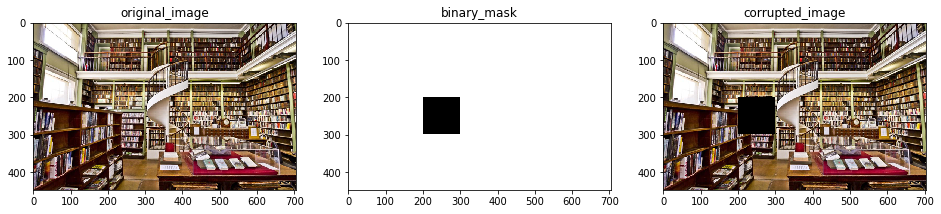

image_normalize_TF:  True
sigmoid_TF:  True

model structure: 
(1, 224, 352, 16)
(1, 112, 176, 32)
(1, 56, 88, 64)
(1, 28, 44, 128)
(1, 14, 22, 128)
(1, 14, 22, 132)
(1, 28, 44, 128)
(1, 56, 88, 128)
(1, 112, 176, 64)
(1, 224, 352, 32)
(1, 448, 704, 16)
(1, 448, 704, 3)

Go Training...
iter:    0/5000, training loss: 126975.71875000, use time: 5.064,psnr: 8.433
iter:  100/5000, training loss: 45846.63671875, use time: 8.818,psnr: 12.828
iter:  200/5000, training loss: 38267.96875000, use time: 8.944,psnr: 13.593
iter:  300/5000, training loss: 31397.25781250, use time: 8.907,psnr: 14.354
iter:  400/5000, training loss: 24986.01367188, use time: 8.908,psnr: 15.226
iter:  500/5000, training loss: 19728.31835938, use time: 8.936,psnr: 16.080
iter:  600/5000, training loss: 14947.13085938, use time: 8.974,psnr: 17.173
iter:  700/5000, training loss: 12254.20996094, use time: 9.054,psnr: 18.115
iter:  800/5000, training loss: 10179.00781250, use time: 8.991,psnr: 18.766
iter:  900/5000, tra

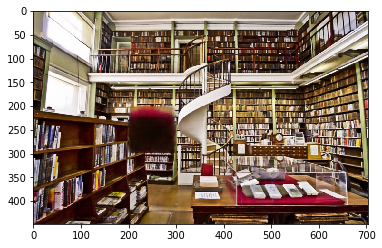

In [132]:
## run

# lena for text remove
# library for inpainting

## hyper-parameter
n_u_list = n_d_list = [16, 32, 64, 128, 128]
k_u_list = k_d_list = [7, 7, 7, 7, 7]
n_s_list = [0, 0, 0, 0, 4]
k_s_list = [0, 0, 0, 0, 1] 

LR = 0.01   ## learning rate
num_iter = 5000
save_every_iter = 100
show_every_iter = 500

## some TF setting
image_normalize_TF = True
sigmoid_TF = True
addReg = True
task = 'inpainting'
maskType = 'hole'
des = '_TV'
## load image
input_image_name = 'library'
input_file = './pic_input/' + input_image_name + '.png'
input_image = np.array(Image.open(input_file))[:, :, :3]

if addReg:
    output_path = './pic_output/addReg/' + input_image_name + '_'
    weight = 0.01
    output_path = output_path + task + '_lr' + str(LR) + '_' + maskType + '_w' + str(weight) + des + '/'
    
else:
    output_path = './pic_output/noReg/'+ input_image_name + '_'
    output_path = output_path + task + '_' + str(LR) + '_' + maskType  + des + '/'
    
output_file_name = 'epoch'
    
# get mask
if maskType == 'text':
    binary_mask_1 = get_binary_text_mask(input_image, sz=30, position=(0, 100), 
                                         text='This course introduces the\n fundamentals of designing \n computer vision systems—that can \n "look at" images and videos and reason \n about the physical objects \n and scenes they represent.')
    binary_mask_2 = get_binary_text_mask(input_image, sz=25, position=(250, 300), 
                                         text='')
    binary_mask = np.multiply(binary_mask_1, binary_mask_2)
else:
#     h,w,c = input_image.shape 
#     binary_mask = np.ones((h,w,c))
#     xmin = 40-1
#     ymin = 102-1
#     width = 142-1
#     height = 108-1
#     binary_mask[ymin:ymin+height,xmin:xmin+width,:] = 0
    h,w,c = input_image.shape 
    binary_mask = np.ones((h,w,c))
    binary_mask[200:300,200:300,:] = 0
    


ok_image = text_inpainting(input_image, n_u_list, n_d_list, 
                           k_u_list, k_d_list, n_s_list, k_s_list, 
                           LR, num_iter, save_every_iter, 
                           show_every_iter, output_path, output_file_name, 
                           image_normalize_TF, sigmoid_TF,addReg,binary_mask,weight)